In [1]:
# RUN THIS FILE SECOND, AFTER THE SIMPLE NETWORK

import os
import struct
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

/Users/thomasklein/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Paths
# adjust these two 
mnist_path = "/Users/thomasklein/Uni/5. Semester/TensorFlow/Hausaufgaben/MNIST/MNIST_data" # path to data, might be different from source code location
global_path = "/Users/thomasklein/Uni/5. Semester/TensorFlow/final task/" # main folder

# are already relative to main folder
logs_path = global_path+"Summaries/" # summary data for Tensorboard goes here
save_path = global_path+"Checkpoints/" # Checkpoints of Saver Class go here
datagraph_path = global_path+"graph_data/" # network performance values are stored here to be plotted later
samples_path = global_path+"Samples_Simple/" # adversarial samples to be applied to the CNN later are stored here

In [3]:
# The MNIST-helper-class, as provided by Lukas for one of the first tensorflow-tasks. The only difference is that we
# scaled the data to be between 0 and 1 instead of 0 and 255, because otherwise, we need to scale our epsilon.

class MNIST():
    def __init__(self, directory):
        self._directory = directory
        
        self._training_data = self._load_binaries("train-images-idx3-ubyte")
        self._training_labels = self._load_binaries("train-labels-idx1-ubyte")
        self._test_data = self._load_binaries("t10k-images-idx3-ubyte")
        self._test_labels = self._load_binaries("t10k-labels-idx1-ubyte")
   
        np.random.seed(0)
        samples_n = self._training_labels.shape[0]
        random_indices = np.random.choice(samples_n, samples_n // 10, replace = False)
        np.random.seed()
        
        self._validation_data = self._training_data[random_indices]
        self._validation_labels = self._training_labels[random_indices]
        self._training_data = np.delete(self._training_data, random_indices, axis = 0)
        self._training_labels = np.delete(self._training_labels, random_indices)
    
    def _load_binaries(self, file_name):
        path = os.path.join(self._directory, file_name)
        
        with open(path, 'rb') as fd:
            check, items_n = struct.unpack(">ii", fd.read(8))

            if "images" in file_name and check == 2051:
                height, width = struct.unpack(">II", fd.read(8))
                images = np.fromfile(fd, dtype = 'uint8')
                return np.reshape(images, (items_n, height, width))
            elif "labels" in file_name and check == 2049:
                return np.fromfile(fd, dtype = 'uint8')
            else:
                raise ValueError("Not a MNIST file: " + path)
    
    
    def get_training_batch(self, batch_size):
        return self._get_batch(self._training_data, self._training_labels, batch_size)
    
    def get_validation_batch(self, batch_size):
        return self._get_batch(self._validation_data, self._validation_labels, batch_size)
    
    def get_test_batch(self, batch_size):
        return self._get_batch(self._test_data, self._test_labels, batch_size)
    
    def _get_batch(self, data, labels, batch_size):
        samples_n = labels.shape[0]
        if batch_size <= 0:
            batch_size = samples_n
        
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = data[random_indices]
        labels = labels[random_indices]
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off]/255, labels[on:off]
    
    
    def get_sizes(self):
        training_samples_n = self._training_labels.shape[0]
        validation_samples_n = self._validation_labels.shape[0]
        test_samples_n = self._test_labels.shape[0]
        return training_samples_n, validation_samples_n, test_samples_n
    
    def get_one_image(self):
        index = np.random.choice(len(self._training_data), replace = False)
        img = self._training_data[index].flatten()
        label = self._training_labels[index]
        return img
    
    def show_image(self):
        """
        Randomly chooses one image from the training data and displays both the image and the
        corresponding label.
        """
        index = np.random.choice(len(self._training_data), replace = False)
        img = self._training_data[index]
        label = self._training_labels[index]
        
        plt.figure()
        plt.imshow(img)
        plt.show()
        
        print("Label:  ", label)
        return img
    
mnist = MNIST(mnist_path)

In [4]:
# The Data Flow Graph for our second experiment: Using a simple CNN to classify handwritten digits. 
# Theoretically, this network should perform much better after adversarial training.

tf.reset_default_graph()

# hyperparameters
first_convolution_maps = 16    # number of feature maps in first layer
first_convolution_size = 5     # kernel size in first layer
second_convolution_maps = 32   # number of feature maps in second layer
second_convolution_size = 3    # kernel size in second layer
fully_connected = second_convolution_maps * 49 # needed for read-out layer

# placeholders for input image and label
input_img = tf.placeholder(tf.float32,[None,28,28])
x = tf.reshape(input_img, [-1, 28, 28, 1])
labels = tf.placeholder(tf.int64,[None])

# first convolutional layer
# we use relus, so the variance of the weight distribution should be 2/fan-in
initializer = tf.random_normal_initializer(stddev = 2/(first_convolution_size**2))
kernels_1 = tf.Variable(initializer([first_convolution_size,first_convolution_size,1,first_convolution_maps]))
bias_1 = tf.Variable(tf.constant(0.0, shape=[first_convolution_maps]))

convolution_1 = tf.nn.conv2d(x, kernels_1, strides = [1, 1, 1, 1], padding = "SAME")
activation_1 = tf.nn.relu(convolution_1 + bias_1)

# first max pooling layer
pooling_1 = tf.nn.max_pool(activation_1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME")

# second convolutional layer
initializer = tf.random_normal_initializer(stddev = 2/(first_convolution_maps * second_convolution_size**2))
kernels_2 = tf.Variable(initializer([second_convolution_size,second_convolution_size,first_convolution_maps,second_convolution_maps]))
bias_2 = tf.Variable(tf.constant(0.0, shape = [second_convolution_maps]))

convolution_2 = tf.nn.conv2d(pooling_1, kernels_2, strides = [1, 1, 1, 1], padding = "SAME")
activation_2 = tf.nn.relu(convolution_2 + bias_2)

# second max pooling layer
pooling_2 = tf.nn.max_pool(activation_2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME")

# first read-out layer
initializer = tf.random_normal_initializer(stddev = fully_connected**(-1/2))
read_out_weights_1 = tf.Variable(initializer([fully_connected,512]))
bias_3 = tf.Variable(tf.constant(0.0, shape = [512]))
reshaped = tf.reshape(pooling_2, [-1,fully_connected])
activation_3 = tf.nn.tanh(tf.matmul(reshaped, read_out_weights_1 ) + bias_3)

# second read-out layer
# read-out layer uses tanh acitvation, so different weight initialization
initializer = tf.random_normal_initializer(stddev = 512**(-1/2))
read_out_weights_2 = tf.Variable(initializer([512, 10]))
bias_4 = tf.Variable(tf.constant(0.0, shape= [10]))
activation_4 = tf.nn.tanh(tf.matmul(activation_3, read_out_weights_2) + bias_4)

softmax = tf.nn.softmax(activation_4)

# extracting the predicted label
predicted_label = tf.argmax(activation_4, axis=1)

# calculating the accuracy 
comparison = tf.equal(labels, predicted_label)
accuracy = tf.divide(tf.reduce_sum(tf.cast(comparison, dtype=tf.int32)), tf.size(comparison))
tf.summary.scalar("accuracy", accuracy)

# calculating the cross entropy
cross_entropies = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = activation_4, labels = labels)
mean_cross_entropy = tf.reduce_mean(cross_entropies)
tf.summary.scalar("crossentropy", mean_cross_entropy)

summary_node = tf.summary.merge_all()
# Define optimizer and minimize the mean cross entropy 
# Adadelta and Adam worked well for us

#optimizer = tf.train.AdadeltaOptimizer(0.15)
optimizer = tf.train.AdamOptimizer()

# minimizing the cross entropy 
optimization_step = optimizer.minimize(mean_cross_entropy)

# to generate adversarial examples using the fast gradient sign method, we need to calculate the gradient of the loss
# with respect to the input image. tf.gradient does just that, yielding a matrix with same dimensions as training images
gradients = tf.gradients(mean_cross_entropy,input_img)


In [5]:
# Training the network. We use batches of size 50 and 3 episodes. Cross entropy and accuracy of the resulting 
# predictions are monitored using TensorBoard.

batch_size = 50
episodes = 3

with tf.Session() as session:
    
    session.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    writer = tf.summary.FileWriter(logs_path+"regular_CNN", session.graph)
    
    step = 0
    for episode in range(episodes):
        for batch, label in mnist.get_training_batch(batch_size):
            
            run_metadata = tf.RunMetadata() # seems to be necessary for filewriter
            
            # performing one optimization step per batch, writing a summary
            label = np.int64(label)
            _opt_step, _summary = session.run([optimization_step, summary_node], 
                                              feed_dict={input_img:batch, labels:label})
            
            writer.add_run_metadata(run_metadata, 'step'+str(step))
            writer.add_summary(_summary, step)
            
            step = step + 1
            
    # regular_model now contains a CNN that was trained on regular images
    regular_model = saver.save(session, save_path+"regularCNN.ckpt", global_step = step)

        

In [6]:
def generate_adversarial(session, epsilon, batch, label):
    """
    Generates an adversarial example using the fast gradient sign method.
    
    session = the tensorflow session to be used
    epsilon = the epsilon for the disturbance
    batch   = the training batch containing one image (batch with one element)
    label   = the real label of batch
    
    Returns an adversarial image with same dimensions as original image.
    """
    _gradient = session.run([gradients], feed_dict={input_img:batch, labels:label})
    
    eta = []
    for grad in _gradient:
        eta.append(epsilon * np.sign(grad))

    eta = np.reshape(np.array(eta),[28,28]) # match image dimensions

    adversarial = batch[0]+eta
    
    return adversarial

INFO:tensorflow:Restoring parameters from /Users/thomasklein/Uni/5. Semester/TensorFlow/final task/Checkpoints/regularCNN.ckpt-3240
Class Probabilities for undisturbed image:
 [[0.0610183  0.06101617 0.4508519  0.06101617 0.06101617 0.06101617
  0.06101617 0.06101617 0.06101663 0.06101617]]


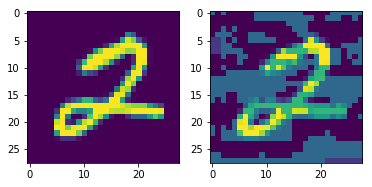

Predicted Label: [2]
Class Probabilities for adversarial example:
 [[0.31215158 0.04469719 0.33024737 0.04469719 0.04469719 0.04469719
  0.04469719 0.04469719 0.0447208  0.04469719]]


In [7]:
# Generating and printing an adversarial example together with its original image.

epsilon = 0.25
with tf.Session() as session:
    
    # restoring session
    saver = tf.train.Saver()
    saver.restore(session,  regular_model)

    for batch, label in mnist.get_training_batch(1):
        # batch is one image, label one number
        
        # receiving the gradients, the drive and the target class probabilities for the image
        # not using our method because we also need those other values, but same code otherwise
        _gradient, _prob = session.run([gradients, softmax], 
                                             feed_dict={input_img:batch, labels:label})
        
        # the class probabilities for the original image
        print("Class Probabilities for undisturbed image:\n", _prob)
        
        # calculating the perturbation that will be applied to the image
        eta = []
        for grad in _gradient:
            eta.append(epsilon * np.sign(grad))
            
        eta = np.reshape(np.array(eta),[28,28]) # reshaping eta to match image dimensions

        # generating the adversarial example
        adversarial = batch[0]+eta
        
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(batch[0])    # printing the original image 
        axarr[1].imshow(adversarial) # printing the adversarial
        #axarr[2].imshow(eta)         # printing the perturbation
        plt.show()
        
        # feeding the adversarial sample into the network to see what it predicts
        _pred_label, _dis_prob = session.run([predicted_label, softmax], 
                                                       feed_dict={input_img:np.reshape(adversarial, [1,28,28])})
        
        print("Predicted Label:",_pred_label)                       # should be different from actual label
                 
        
        print("Class Probabilities for adversarial example:\n",_dis_prob)   # predicted probabilities
        
                
        break

Interestingly, it is sometimes possible to observe distinct box-like structures of large perturbation in the adversarial examples that were generated by the CNN.

In [8]:
# generating batch of adversarial examples to calculate a stable value for the accuracy

epsilon = 0.25
samples = 1000
adversarials = [] # used to store samples
real_labels = []  # used to store labels of samples

# measuring ssim between original and adversarial to obtain average difference as metric
from skimage.measure import compare_ssim as ssim

with tf.Session() as session:
    
    # restoring session
    saver = tf.train.Saver()
    saver.restore(session,  regular_model)
    
    ssim_difference = 0
    mad = 0
    
    number = 0 # just a counter for how many samples were generated yet
    for batch, label in mnist.get_training_batch(1):
        # batch is one image, label one number
        
        adversarial = generate_adversarial(session, epsilon, batch, label)
        
        ssim_difference += ssim(np.reshape(batch,(28,28)), adversarial,
                               data_range= adversarial.max()-adversarial.min())
        
        mad += np.mean(np.abs(np.reshape(batch,(28,28)) - adversarial))
        
        adversarials.append(adversarial)
        real_labels.append(label)
        
        if( number == samples):
            break
        number = number + 1
        
    print("Average structural similarity between original and adversarial:",ssim_difference/number)
    # MAD should equal epsilon, within some margin of error
    print("Mean absolute difference between original and adversarial:",mad/number)
    
    # measuring performance on adversarial examples
    correct = 0
    for index, adversarial in enumerate(adversarials):
        
        l = np.int64(real_labels[index])
        _predicted_label = session.run(predicted_label, 
                                            feed_dict={input_img:np.reshape(adversarial, [1,28,28]), labels:l})
        
        # uncomment this to see direct comparison of real and predicted label, should be wrong all the time
        #print("predicted:", _predicted_label, "real:", real_labels[index])
        
        if(_predicted_label == real_labels[index]): # prediction was correct
            correct = correct + 1
    
    print("Accuracy with epsilon",epsilon,"was",correct/samples, "which means that the adversarial worked",(1-(correct/samples))*100,"% of the time.")
    

INFO:tensorflow:Restoring parameters from /Users/thomasklein/Uni/5. Semester/TensorFlow/final task/Checkpoints/regularCNN.ckpt-3240
Average structural similarity between original and adversarial: 0.4986332461939899
Mean absolute difference between original and adversarial: 0.23625414540816334
Accuracy with epsilon 0.25 was 0.193 which means that the adversarial worked 80.69999999999999 % of the time.


INFO:tensorflow:Restoring parameters from /Users/thomasklein/Uni/5. Semester/TensorFlow/final task/Checkpoints/regularCNN.ckpt-3240


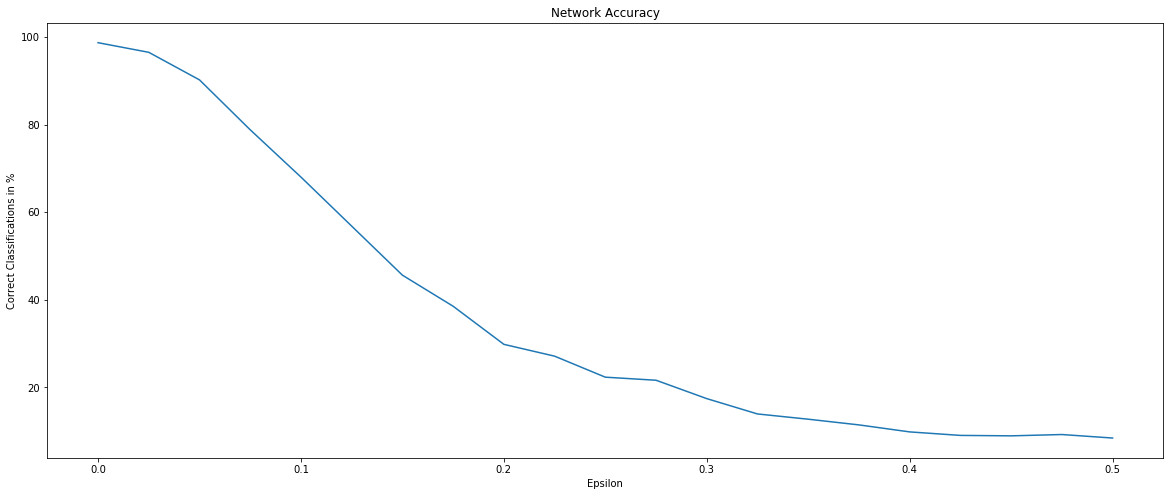

In [9]:
# exploring different values for epsilon, starting at zero, going up to .5

samples_per_epsilon = 1000 # how many samples to generate for each epsilon

with tf.Session() as session:

    # restoring session
    saver = tf.train.Saver()
    saver.restore(session,  regular_model)
    
    # used for storing values for plotting 
    xvals = []
    yvals = []
    
    for i in range(21): # 2.5 percent steps
        epsilon = i * 0.025
        
        number = 0
        correct = 0
        
        for batch, label in mnist.get_test_batch(1):
            
            # generating an adversarial example
            adversarial = generate_adversarial(session, epsilon, batch, label)
            
            # making a prediction
            label = np.int64(label)
            _predicted_label = session.run(predicted_label, 
                                            feed_dict={input_img:np.reshape(adversarial, [1,28,28]), labels:label})
        
            if(_predicted_label == label): # prediction was correct
                correct = correct + 1
            
            # we have generated enough samples
            if(number == samples_per_epsilon):
                
                xvals.append(epsilon)
                yvals.append(correct/samples_per_epsilon*100)#(((1-(correct/samples_per_epsilon))*100))
                
                # uncomment this to see which epsilon value caused which percentage of missclassifications
                #print("Epsilon of %.2f" % epsilon,"fooled the network %.2f" % ((1-(correct/samples_per_epsilon))*100),"% of the time.")
                break
                
            number = number + 1
    
    # storing values for regularCNN
    output = open(datagraph_path+"regularCNN.pkl", 'wb')
    pickle.dump(yvals, output, -1)
    output.close()

    # storing x-values 
    output = open(datagraph_path+"xval.pkl", 'wb')
    pickle.dump(xvals, output, -1)
    output.close()
    
    # plotting results
    plt.figure(figsize=(20,8))
    plt.plot(xvals,yvals)
    plt.ylabel("Correct Classifications in %")
    plt.xlabel("Epsilon")
    plt.title("Network Accuracy")
    plt.show()


In [10]:
# Preparation for adversarial training. Again, we generate 54.000 adversarial examples and store them in a list.

epsilon = 0.25
batchsize = 50
adversarials = [] # used to store samples
real_labels = []  # used to store labels of samples

with tf.Session() as session:
    
    # restoring session
    saver = tf.train.Saver()
    saver.restore(session,  regular_model)
    
    writer = tf.summary.FileWriter(logs_path+"Adversarial_Training_CNN", session.graph)
    
    # generate 54.000 adversarial samples
    for batch, label in mnist.get_training_batch(1):
        # batch is one image, label one number
        adversarial = generate_adversarial(session, epsilon, batch, label)
        adversarials.append(adversarial)
        real_labels.append(label)
        
    

INFO:tensorflow:Restoring parameters from /Users/thomasklein/Uni/5. Semester/TensorFlow/final task/Checkpoints/regularCNN.ckpt-3240


In [11]:
# ADVERSARIAL TRAINING 
# the ratio of real to fake examples is again 50/50.

with tf.Session() as session:
    # reset the network
    session.run(tf.global_variables_initializer())
    
    step = 0
    episodes = 3
    
    for e in range(episodes):
        begin = 0
        end = batchsize
        for batch, label in mnist.get_training_batch(batchsize):

            batch = np.append(batch, adversarials[begin:end], axis=0)
            label = np.append(label, real_labels[begin:end])

            run_metadata = tf.RunMetadata()

            _opt_step, _summary = session.run([optimization_step, summary_node], feed_dict={input_img:batch, labels:np.int64(label)})

            writer.add_run_metadata(run_metadata, 'step'+str(step))
            writer.add_summary(_summary, step)

            step = step + 1

            begin += batchsize
            end += batchsize
            
    adversarial_model = saver.save(session, save_path+"adversarialCNN.ckpt", global_step = step)

INFO:tensorflow:Restoring parameters from /Users/thomasklein/Uni/5. Semester/TensorFlow/final task/Checkpoints/adversarialCNN.ckpt-3240


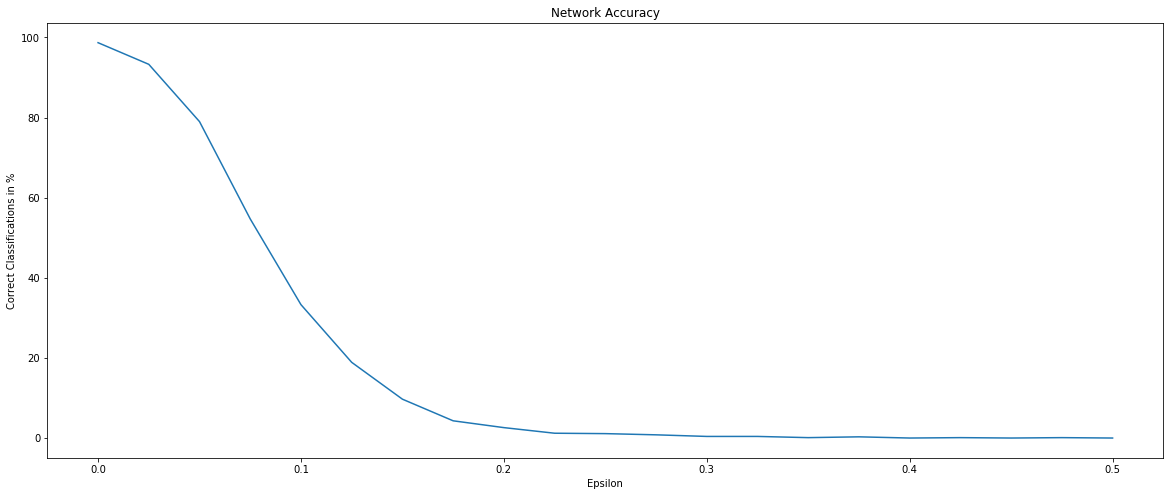

In [12]:
# same test again with network that went through adversarial training
# different values for epsilon, starting at zero, going up to .5

samples_per_epsilon = 1000 # how many samples to generate for each epsilon

with tf.Session() as session:

    # restoring session
    saver = tf.train.Saver()
    saver.restore(session,  adversarial_model)
    
    # used for storing values for plotting 
    xvals = []
    yvals = []
    
    for i in range(21): # 2.5 percent steps
        epsilon = i * 0.025
        
        number = 0
        correct = 0
        
        for batch, label in mnist.get_test_batch(1):
            
            # generating an adversarial example
            adversarial = generate_adversarial(session, epsilon, batch, label)
            
            # making a prediction
            label = np.int64(label)
            _predicted_label = session.run(predicted_label, 
                                            feed_dict={input_img:np.reshape(adversarial, [1,28,28]), labels:label})
        
            if(_predicted_label == label): # prediction was correct
                correct += 1
            
            # we have generated enough samples
            if(number == samples_per_epsilon):
                
                xvals.append(epsilon)
                yvals.append(correct/samples_per_epsilon*100)#(((1-(correct/samples_per_epsilon))*100))
                
                # uncomment this to see which epsilon value caused which percentage of missclassifications
                #print("Epsilon of %.2f" % epsilon,"fooled the network %.2f" % ((1-(correct/samples_per_epsilon))*100),"% of the time.")
                break
                
            number = number + 1
    
    # storing values for adversarialCNN
    output = open(datagraph_path+"adversarialCNN.pkl", 'wb')
    pickle.dump(yvals, output, -1)
    output.close()
    
    # plotting results
    plt.figure(figsize=(20,8))
    plt.plot(xvals,yvals)
    plt.ylabel("Correct Classifications in %")
    plt.xlabel("Epsilon")
    plt.title("Network Accuracy")
    plt.show()



In [13]:
# testing performance of the regular CNN on adversarial samples that were generated by the linear model.
# Performance definitely experiences negative impact

with tf.Session() as session:
    
    saver = tf.train.Saver()
    saver.restore(session,  regular_model)
    
    pkl_file = open(samples_path+'adversarials.pkl', 'rb')
    adversarials = pickle.load(pkl_file)
    pkl_file.close()
    
    pkl_file = open(samples_path+"labels.pkl", 'rb')
    label = pickle.load(pkl_file)
    pkl_file.close()
    
    correct = 0
    for index, adv in enumerate(adversarials):
        _predicted = session.run(predicted_label, 
                                 feed_dict={input_img:np.reshape(adv, [1,28,28]), labels:label[index]})
        
        if(_predicted == label[index]):
            correct += 1
    
    print("Accuracy:",correct/len(label))
    

INFO:tensorflow:Restoring parameters from /Users/thomasklein/Uni/5. Semester/TensorFlow/final task/Checkpoints/regularCNN.ckpt-3240
Accuracy: 0.611


In [14]:
# This time, we test the CNN that underwent adversarial training.
# Performance is significantly better than regular CNN, but still not as good as on real examples.

with tf.Session() as session:
    
    saver = tf.train.Saver()
    saver.restore(session,  adversarial_model)
    
    # loading adversarial examples and corresponding labels
    pkl_file = open(samples_path+'adversarials.pkl', 'rb')
    adversarials = pickle.load(pkl_file)
    pkl_file.close()
    
    pkl_file = open(samples_path+"labels.pkl", 'rb')
    label = pickle.load(pkl_file)
    pkl_file.close()
    
    correct = 0
    for index, adv in enumerate(adversarials):
        _predicted = session.run(predicted_label, 
                                 feed_dict={input_img:np.reshape(adv, [1,28,28]), labels:label[index]})
        
        if(_predicted == label[index]):
            correct += 1
    
    print("Accuracy:",correct/len(label))
    

INFO:tensorflow:Restoring parameters from /Users/thomasklein/Uni/5. Semester/TensorFlow/final task/Checkpoints/adversarialCNN.ckpt-3240
Accuracy: 0.648


## Summary ##
In this notebook, we recreated the first experiment with the same setup, but a different neural network. This time, we used a Convolutional Neural Network with three layers of convolution and max-pooling, followed by a small readout network. 

We observed that the baseline error rate of the CNN was far lower than the one of the linear regression model, which fits well with our hypothesis that a more complex model with less obvious linearity would be more resistant against adversarial perturbations. The network only failed about 80% of the time, as compared to the linear model which failed more than 95% of the time. Subsequent tests showed that a higher value for epsilon is required to achieve comparable failure rates. 

Again, the more surprising results presented themselves when we trained the model on adversarial examples, because model accuracy declined rapidly and even dropped below the performance level of the linear model. So far, we have no explanation for this behaviour. 

Another test that we conducted is whether adversarial samples that were generated by the linear model would also work for the more complex CNN. And indeed, they did. The CNN achieved an accuracy of only 52% on the adversarial examples that were generated by the linear model. This is way better than the network's perfomance on its own adversarials, but way lower than the performance of the network on undisturbed images, which comes close to 100%. So the network certainly was fooled. 

We then tested the network that underwent adversarial training on the adversarial examples that were generated by the linear model. This version of the CNN reached an accuracy of 71%, strongly suggesting that adversarial training does indeed increase the network's resistance against adversarials, if only simpler ones.